In [12]:
# !pip install plotly
# !pip install pandas
import pandas as pd
# !pip install pandas_ta
# import pandas_ta as ta
import numpy as np
# !pip install seaborn
import seaborn as sns
import datetime
from datetime import timedelta
import math
import requests
import plotly as py
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt


import sklearn as sk
import sklearn.preprocessing
from sklearn import metrics
from matplotlib.pyplot import figure

from sklearn.preprocessing import  (StandardScaler, MinMaxScaler, LabelBinarizer)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.metrics import *
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree

from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
# !pip install graphviz
# import graphviz
# import chart_studio.tools as tls

# Creating DataFrame

In [13]:
#manipulatable variables
numDaysBack = str(365*5) #for daily you can go back multiple years worth, for daily you can only go back 90 days
myInterval = 'daily' # options are daily or hourly
theCoins = ['ethereum'] #can add more than one coin if you like
window_length = 14
mycom = 0.4
lower_macd_ema = 12
upper_macd_ema = 26
trigger_macd_ema = 9


def df_builder_clean(days, interval, coins, window, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    #manipulatable variables
    numDaysBack = days #for daily you can go back multiple years worth, for daily you can only go back 90 days
    myInterval = interval # options are daily or hourly
    theCoins = coins
    window_length = window

    #builds initial dataframe with ethereum as first market but just to log the dates we are working with
    geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''
    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    ts = ts/1000
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        currentUnix = currentUnix/1000
#         currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%d-%m-%Y %H:%M:%S") #adding dd-mm-yyyy hours minutes seconds
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y") #just the date mm-dd-yyyy
        HistPricesList.append([currentTS])
    global df
    df = pd.DataFrame(HistPricesList, columns = ['date'])

    
    #looping through each coin and adding in all data points and input variables
    for coin in theCoins:
        price_data(coin)
        add_ewm(coin, mycom)
        add_rsi(coin, window_length)
        add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema)
        print('just added: ', coin)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
#     print('r')
#     display(r)
    return df


def price_data(coin):
    global df
    # geckoReq = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=60&interval=daily'
    geckoReq = 'https://api.coingecko.com/api/v3/coins/'+coin+'/market_chart?vs_currency=usd&days='+numDaysBack+'&interval='+myInterval+''

    r = requests.get(geckoReq).json()
    ts = r['prices'][0][0]
    # print(ts)
    ts = ts/1000
    print(datetime.datetime.fromtimestamp(ts).strftime("%m-%d-%Y"))
    # print('prices length',len(r['prices']))
    HistPricesList = []
    for i in range(len(r['prices'])):
        currentUnix = r['prices'][i][0] 
        price = r['prices'][i][1]
        volume = r['total_volumes'][i][1]
        currentUnix = currentUnix/1000
        currentTS = datetime.datetime.fromtimestamp(currentUnix).strftime("%m-%d-%Y")
    #     print('price: ', price, 'TS: ', currentTS)
        HistPricesList.append([currentTS, price, volume])
    #     currentUnix = currentTS
#         print(HistPricesList)
    dfCoin = pd.DataFrame(HistPricesList, columns = ['date', coin, coin+'_volume'])
#     print('dfCoin')
#     display(dfCoin)
    df = pd.merge(df, dfCoin[coin], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    df = pd.merge(df, dfCoin[coin+'_volume'], left_on = df['date'], right_on=dfCoin['date']).drop(['key_0'], axis = 1)
    
def add_ewm(coin, mycom):
    df[coin+'_ewm'] = df[coin].ewm(com=mycom).mean()
    
def add_rsi(coin, window_length):
    global df
    df['diff'] = df[coin].diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
        
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    df = pd.DataFrame(df)
    df = df.drop(['gain', 'loss', 'avg_loss', 'avg_gain', 'rs'], axis = 1)
    
    #renaming diff and rsi columns
    dict = {'diff': coin+'_diff',
        'rsi': coin+'_rsi'}
    df.rename(columns=dict,
              inplace=True)

def add_macd(coin, lower_macd_ema, upper_macd_ema, trigger_macd_ema):
    global df
    #get ema for lower
    k = df[coin].ewm(span=lower_macd_ema, adjust = False, min_periods = lower_macd_ema).mean()

    #get ema for upper
    d = df[coin].ewm(span=upper_macd_ema, adjust=False, min_periods=upper_macd_ema).mean()

    macd = k-d
    
    # Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=trigger_macd_ema, adjust=False, min_periods=trigger_macd_ema).mean()
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    # Add all of our new values for the MACD to the dataframe
    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_h)
    df['macd_s'] = df.index.map(macd_s)



mydf = pd.DataFrame(df_builder_clean(numDaysBack, myInterval, theCoins, window_length, mycom, lower_macd_ema, upper_macd_ema, trigger_macd_ema))
display(mydf)



08-03-2017


C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


just added:  ethereum


,ethereum,ethereum_volume,ethereum_ewm,ethereum_diff,ethereum_rsi,macd,macd_h,macd_s
date,,,,,,,,
2017-08-03,221.674960,2.035056e+08,221.674960,NaN,NaN,NaN,NaN,NaN
2017-08-04,253.155666,6.151204e+08,246.159954,31.480707,NaN,NaN,NaN,NaN
2017-08-05,263.222086,6.401036e+08,258.638230,10.066420,NaN,NaN,NaN,NaN
2017-08-06,268.496629,4.353856e+08,265.727184,5.274543,NaN,NaN,NaN,NaN
2017-08-07,295.147098,6.785731e+08,286.781495,26.650469,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-07-29,1739.042177,2.179260e+10,1723.264640,15.493656,67.731944,106.901037,31.467895,75.433141
2022-07-30,1696.785098,1.423678e+10,1704.350682,-42.257079,64.487556,110.585681,28.122032,82.463649
2022-07-31,1682.011374,1.289460e+10,1688.394033,-14.773725,63.345491,111.033744,22.856076,88.177668


In [14]:
mydf.dropna(inplace=True)
myCols = ['ethereum', 'ethereum_volume', 'ethereum_ewm', 'ethereum_rsi', 'macd', 'macd_h', 'macd_s', 'ethereum_diff']

In [15]:
my_data = mydf[myCols]
# display(my_data.tail(10))
my_data.drop(my_data.tail(10).index,
        inplace = True)
display(my_data)

C:\Users\fooba\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,ethereum,ethereum_volume,ethereum_ewm,ethereum_rsi,macd,macd_h,macd_s,ethereum_diff
date,,,,,,,,
2017-09-05,333.206330,6.724717e+08,328.788060,56.152041,14.462878,-6.748079,21.210956,14.233526
2017-09-06,329.415663,4.313942e+08,329.236347,54.963988,12.759120,-6.761469,19.520589,-3.790667
2017-09-07,304.475108,6.603927e+08,311.549748,47.797343,9.289303,-8.185028,17.474332,-24.940554
2017-09-08,299.694444,3.155160e+08,303.081674,46.544709,6.083562,-9.112616,15.196178,-4.780664
2017-09-09,292.779657,4.568185e+08,295.723090,44.720148,2.951006,-9.796138,12.747144,-6.914788
...,...,...,...,...,...,...,...,...
2022-07-19,1542.629821,2.774909e+10,1531.497068,66.463819,36.191110,61.231744,-25.040634,-28.029137
2022-07-20,1527.413931,2.172813e+10,1528.580542,65.230806,50.760489,60.640899,-9.880409,-15.215891
2022-07-21,1576.825239,1.941141e+10,1563.041040,67.348533,65.538421,60.335064,5.203357,49.411309


# sliding window

### train test split and create sliding window

In [16]:
seq=list(mydf['ethereum'])
# display(seq)
scaler = StandardScaler()
window_size = 15
sliding_window=[]
for i in range(len(seq) - window_size + 1):
    sliding_window.append(seq[i: i + window_size])
    
# print(sliding_window)

sliding_df = pd.DataFrame(sliding_window)

sliding_df = sliding_df.drop(columns=[1,2,3,4,5])
display(sliding_df)
y = sliding_df[0]
X = sliding_df.drop(columns=[0]) 
X=scaler.fit_transform(X)
# print('X')
# display(X)
# print('y')
# display(y)
# X = X.shift(1, freq='d')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_train = X[:-360]
X_test = X[-360:]
y_train = y[:-360]
y_test = y[-360:]
print('X_train: ')
print(X_train.shape)
print('X_test: ')
print(X_test.shape)
print('y_train: ')
print(y_train.shape)
print('y_test: ')
print(y_test.shape)


,0,6,7,8,9,10,11,12,13,14
0,333.206330,290.586532,277.333658,214.311714,246.921857,244.805612,249.666546,287.961096,280.445632,279.417649
1,329.415663,277.333658,214.311714,246.921857,244.805612,249.666546,287.961096,280.445632,279.417649,257.465074
2,304.475108,214.311714,246.921857,244.805612,249.666546,287.961096,280.445632,279.417649,257.465074,263.469774
3,299.694444,246.921857,244.805612,249.666546,287.961096,280.445632,279.417649,257.465074,263.469774,283.222159
4,292.779657,244.805612,249.666546,287.961096,280.445632,279.417649,257.465074,263.469774,283.222159,280.681045
...,...,...,...,...,...,...,...,...,...,...
1774,1234.099139,1576.825239,1536.124922,1552.496489,1601.207967,1450.482285,1438.988038,1636.949181,1723.548521,1739.042177
1775,1355.045640,1536.124922,1552.496489,1601.207967,1450.482285,1438.988038,1636.949181,1723.548521,1739.042177,1696.785098
1776,1344.720284,1552.496489,1601.207967,1450.482285,1438.988038,1636.949181,1723.548521,1739.042177,1696.785098,1682.011374
1777,1570.658959,1601.207967,1450.482285,1438.988038,1636.949181,1723.548521,1739.042177,1696.785098,1682.011374,1636.018556


X_train: 
(1419, 9)
X_test: 
(360, 9)
y_train: 
(1419,)
y_test: 
(360,)


### xgboost on sliding window

Root Mean squared error train: 351.58
Root Mean squared error test: 1531.85
r2_score train:  0.7436920861544694
r2_score test:  -1.669269337288803


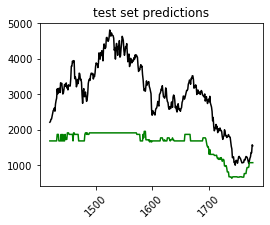

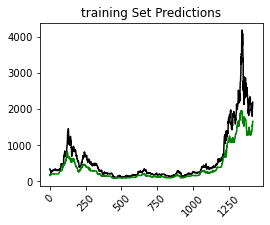

In [17]:

xg_reg=xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree=0.3, learning_rate=0.1,
                        max_depth=5,alpha=10,n_estimators=10)
xg_reg.fit(X_train,y_train)
y_pred_test=xg_reg.predict(X_test)
y_pred_train=xg_reg.predict(X_train)
# rmse=np.sqrt(mean_squared_error(y_test,preds))
# print(preds)
# print(y_check1)
# print('xgb rmse: ', rmse)

print("Root Mean squared error train: %.2f" % math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Root Mean squared error test: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred_test)))

print('r2_score train: ', r2_score(y_train, y_pred_train))
print('r2_score test: ', r2_score(y_test, y_pred_test))


y_testc = pd.DataFrame(y_test)
# print(y_check1)
y_testc['pred_linear_reg']= y_pred_test
# print(y_check1)
figure(figsize=(4, 3))
plt.plot(y_testc.index,y_testc[0], color = 'black')
plt.plot(y_testc.index,y_testc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('test set predictions')
plt.show()


y_trainc = pd.DataFrame(y_train)
# print(y_check1)
y_trainc['pred_linear_reg']= y_pred_train
# print(y_check1)
figure(figsize=(4, 3))
plt.plot(y_trainc.index,y_trainc[0], color = 'black')
plt.plot(y_trainc.index,y_trainc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('training Set Predictions')

plt.show()

## hyperparameter tuning on sliding windows feature set

In [18]:
parameters = {
    'max_depth': range (2, 10, 1),
    'booster': ['gbtree', 'gblinear'],
#     'n_estimators': range(0, 1000, 50),
    'n_estimators': [10,50,60,200,500,1000],
    'learning_rate': [0.1, 0.01, 0.05]
#     'eval_metric': ['rmse', 'mae', 'mape']
}
grid_search = GridSearchCV(
    estimator=xg_reg,
    param_grid=parameters,
#     scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(alpha=10, base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=0.3,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=0, gpu_id=-1, grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.1, max_bin=256,
                                    max_...ta_step=0,
                                    max_depth=5, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=10,
                                    n_jobs=0, num_parallel_tree=1,
  

Root Mean squared error train: 118.53
Root Mean squared error test: 697.74
r2_score train:  0.9708669958616386
r2_score test:  0.4462099329211411


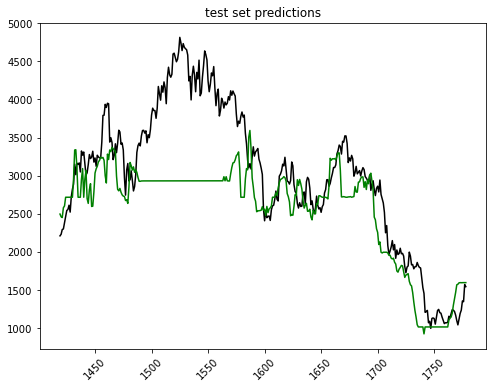

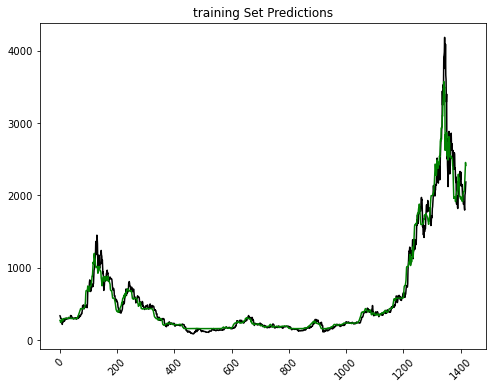

In [19]:
grid_search.best_estimator_
grid_search.best_estimator_.fit(X_train, y_train)
y_pred_test = grid_search.best_estimator_.predict(X_test)
y_pred_train = grid_search.best_estimator_.predict(X_train)
# rmse=np.sqrt(mean_squared_error(y_test,y_pred))

print("Root Mean squared error train: %.2f" % math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Root Mean squared error test: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred_test)))

print('r2_score train: ', r2_score(y_train, y_pred_train))
print('r2_score test: ', r2_score(y_test, y_pred_test))

y_testc = pd.DataFrame(y_test)
# print(y_check1)
y_testc['pred_linear_reg']= y_pred_test
# print(y_check1)
figure(figsize=(8, 6))
plt.plot(y_testc.index,y_testc[0], color = 'black')
plt.plot(y_testc.index,y_testc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('test set predictions')
plt.show()


y_trainc = pd.DataFrame(y_train)
# print(y_check1)
y_trainc['pred_linear_reg']= y_pred_train
# print(y_check1)
figure(figsize=(8, 6))
plt.plot(y_trainc.index,y_trainc[0], color = 'black')
plt.plot(y_trainc.index,y_trainc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('training Set Predictions')

plt.show()

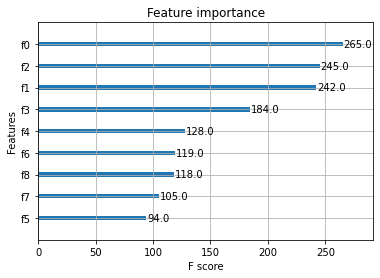

In [20]:
xgb.plot_importance(grid_search.best_estimator_)
plt.rcParams['figure.figsize']=[16,10]
plt.show()

# linear regression on sliding window

Root Mean squared error train: 138.71
Root Mean squared error test: 330.54
r2_score train:  0.9601049352584938
r2_score test:  0.8757160384200414
adjusted r2_score test: 0.872520165122271


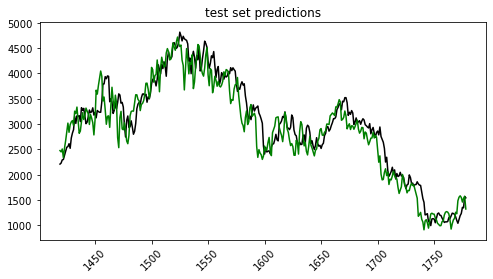

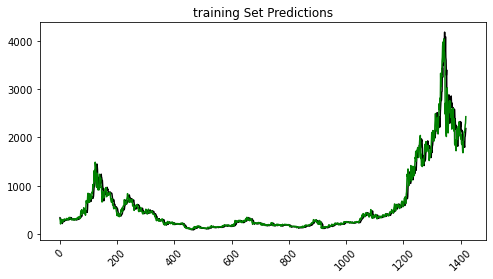

In [21]:
# print('linear regression with no scaling')
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_test = regr.predict(X_test)
y_pred_train = regr.predict(X_train)
# The mean squared error
# print("Root Mean squared error: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred)))

print("Root Mean squared error train: %.2f" % math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Root Mean squared error test: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred_test)))

print('r2_score train: ', r2_score(y_train, y_pred_train))
print('r2_score test: ', r2_score(y_test, y_pred_test))
print('adjusted r2_score test:', 1-(1-r2_score(y_test, y_pred_test))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))

y_testc = pd.DataFrame(y_test)
# print(y_check1)
y_testc['pred_linear_reg']= y_pred_test
# print(y_check1)
figure(figsize=(8, 4))
plt.plot(y_testc.index,y_testc[0], color = 'black')
plt.plot(y_testc.index,y_testc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('test set predictions')
plt.show()


y_trainc = pd.DataFrame(y_train)
# print(y_check1)
y_trainc['pred_linear_reg']= y_pred_train
# print(y_check1)
figure(figsize=(8, 4))
plt.plot(y_trainc.index,y_trainc[0], color = 'black')
plt.plot(y_trainc.index,y_trainc['pred_linear_reg'], color = 'green')
plt.xticks(rotation=45)
plt.title('training Set Predictions')

plt.show()